In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns	

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

from scipy.io import arff
from scipy.stats import zscore

from sklearn.manifold import TSNE,Isomap, trustworthiness


import warnings
warnings.filterwarnings("ignore")

<h3 style="color:orange">Hyperparameters</h3>

In [23]:
Z_THRESHOLD=3.5

color_map = {"Class1":"red","Class2":"#FC00FF","Class12": "red","Class13": "#FC00FF","Most_Common_Combo": "blue","Other": "#C4C4C4"}

if "temp" not in os.listdir("./"): os.makedirs("./temp")          #for debuging
print(f"\u001b[33mZ-Distribution Threshold: \u001b[0m{Z_THRESHOLD}")

Z-Distribution Threshold: 3.5


In [24]:
def continuity(X_high, X_low, n_neighbors=10):
    dist_high = pairwise_distances(X_high)
    dist_low = pairwise_distances(X_low)

    neighbors_high = np.argsort(dist_high, axis=1)[:, 1:n_neighbors+1]
    neighbors_low = np.argsort(dist_low, axis=1)[:, 1:n_neighbors+1]

    n_samples = X_high.shape[0]
    continuity_sum = 0.0

    for i in range(n_samples):
        low_not_high = set(neighbors_low[i]) - set(neighbors_high[i])
        continuity_sum += len(low_not_high)

    max_penalty = n_samples * n_neighbors
    return 1 - (continuity_sum / max_penalty)

<h3 style="color:orange">Load Data</h3>

In [25]:
data=arff.loadarff("./yeast/yeast.arff")
print(data[0].shape)

data=pd.DataFrame(data[0])

## checking duplicate and null values
print(f"\u001b[33mSum Duplicate:\u001b[0m {data.duplicated().sum()}")
print(f"\u001b[33mSum NaN Value: \u001b[0m{data.isna().sum().sum()}")

## Encode catergrical data 
categorical_value=data.iloc[:,103].unique()
print(f"\u001b[33mClasses: \u001b[0m{categorical_value}")
dataclass=data.iloc[:,103:].applymap(lambda x: 0 if x==categorical_value[0] else 1)
data.iloc[:,103:]=dataclass


data.to_csv("./temp/data.csv",index=False)

(2417,)
Sum Duplicate: 0
Sum NaN Value: 0
Classes: [b'0' b'1']


In [26]:
# data.iloc[:,103]
# data
data.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,-0.000773,0.000464,-0.000515,0.000667,0.000324,-0.001483,-0.001047,-0.001539,0.000284,0.007605
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.093316,0.096684,0.096209,0.096635,0.096280,0.094369,0.096900,0.094211,0.093154,0.099368
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,-0.455191,-0.283594,-0.279408,-0.226420,-0.225374,-0.501572,-0.236589,-0.267052,-0.194079,-0.237752
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,-0.054133,-0.056415,-0.056414,-0.059382,-0.058025,-0.053591,-0.063318,-0.059542,-0.054078,-0.077191
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,-0.012893,-0.023595,-0.024313,-0.023059,-0.021942,-0.018216,-0.033623,-0.023519,-0.012007,0.022126
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,0.027977,0.034937,0.036057,0.041430,0.035730,0.019583,0.038901,0.025408,0.028087,0.103185
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,0.609175,0.542867,0.547134,0.385928,0.540493,0.569250,0.509963,0.587358,0.700340,0.163431


<h3 style="color:orange">Dimensionality Check (before EDA)</h3>

In [27]:
# creating x and y data
x=data.iloc[:,:103]
y=data.iloc[:,103:]

print(f"\u001b[33mNumber of Datapoints: \u001b[0m{x.shape[0]}")
print(f"\u001b[33mNumber of Feature: \u001b[0m{x.shape[1]}")
print(f"\u001b[33mNumber of Classes: \u001b[0m{y.shape[1]}")

Number of Datapoints: 2417
Number of Feature: 103
Number of Classes: 14


<h3 style="color:orange">Remove Outliers (using Z-distribution)</h3>

The Z-score standardizes each feature by measuring how many standard deviations a data point lies away from the mean.  
In a normal distribution, approximately 99.7% of values lie within ±3 standard deviations (σ). Samples with any feature exceeding |Z| > 3 were considered statistical outliers and removed.

This method helps eliminate samples with abnormally high or low values, which could distort distance-based algorithms such as t-SNE and Isomap.  

By removing these points, the data becomes more homogeneous, improving the stability of manifold visualizations and preserving the true underlying structure of the yeast dataset.

In [28]:
z_score=np.abs(zscore(x))

data=data[(z_score<Z_THRESHOLD).all(axis=1)]

print(f"\u001b[33m Filtered Shape:\u001b[0m {data.shape}")
print(f"\u001b[33m Removed Outliers:\u001b[0m {x.shape[0]-data.shape[0]}")

data.to_csv("./temp/filterd_dataset.csv")

x=data.iloc[:,:103]
y=data.iloc[:,103:]

 Filtered Shape: (1636, 117)
 Removed Outliers: 781


<h3 style="color:orange">Scaling (Standardization)</h3>

Scaling is essential before applying distance-based dimensionality reduction techniques such as t-SNE and Isomap. Beacuse these methods rely on distances to define local and global structure in the data. If features are not on the same scale, those with larger ranges dominate the distance metric, leading to biased and misleading visualizations.

By applying Standardization we ensures that all features contribute equally to the distance metric

In [29]:
st=StandardScaler()
x[:]=st.fit_transform(x[:])

x=pd.DataFrame(x)
x.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
count,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,...,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03
mean,1.411530e-17,-8.143445e-18,1.302951e-17,1.954427e-17,-1.085793e-17,-1.492965e-17,2.605902e-17,7.600549e-18,2.497323e-17,1.085793e-18,...,1.085793e-18,-1.737268e-17,1.520110e-17,1.194372e-17,-2.768771e-17,4.343171e-18,1.737268e-17,-1.085793e-17,-1.520110e-17,-1.520110e-17
std,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,...,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00
min,-3.590026e+00,-3.413076e+00,-3.292323e+00,-3.546898e+00,-3.273068e+00,-3.297470e+00,-3.254451e+00,-3.395480e+00,-3.456463e+00,-3.464562e+00,...,-3.349995e+00,-2.837189e+00,-3.145058e+00,-2.226152e+00,-2.259953e+00,-2.588612e+00,-1.963672e+00,-2.986319e+00,-2.176976e+00,-2.648456e+00
25%,-5.903430e-01,-6.000106e-01,-6.020694e-01,-5.954088e-01,-6.123845e-01,-6.286637e-01,-6.255513e-01,-6.666159e-01,-6.929692e-01,-6.590400e-01,...,-6.059420e-01,-6.143679e-01,-6.205688e-01,-6.609932e-01,-6.312320e-01,-6.000759e-01,-6.826924e-01,-6.458577e-01,-6.289906e-01,-7.642962e-01
50%,7.550868e-02,-2.841630e-03,3.678261e-02,6.002831e-03,4.928900e-02,1.272917e-03,5.360478e-02,1.339808e-02,5.079404e-02,3.369069e-02,...,-7.381036e-02,-2.498713e-01,-2.372647e-01,-2.435509e-01,-2.161125e-01,-1.372686e-01,-3.519245e-01,-2.178227e-01,-1.054337e-01,1.846308e-01
75%,6.518655e-01,5.419781e-01,6.198458e-01,5.833027e-01,6.744522e-01,5.996141e-01,7.044388e-01,6.414359e-01,6.706786e-01,6.631646e-01,...,3.999175e-01,5.591165e-01,5.677085e-01,5.962464e-01,4.656869e-01,2.869944e-01,5.330767e-01,3.386707e-01,3.652590e-01,9.259626e-01
max,3.311945e+00,3.680580e+00,2.968135e+00,3.472516e+00,3.099003e+00,3.355286e+00,2.850289e+00,3.363351e+00,3.193735e+00,3.154288e+00,...,3.825895e+00,3.201311e+00,3.675990e+00,3.155671e+00,3.288905e+00,3.970335e+00,3.623111e+00,3.755340e+00,3.718228e+00,1.489144e+00


<h3 style="color:orange">PCA for dimensionality reduction</h3>

Shape after PCA: (1636, 56)
Variance explained by the transformed features: 0.9521960809075068


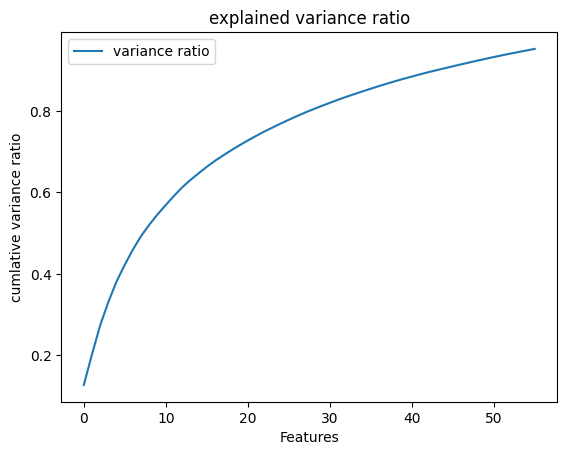

In [41]:
pca=PCA(n_components=0.95,random_state=42)
x=pca.fit_transform(x)

print(f"\u001b[33mShape after PCA: \u001b[0m{x.shape}")
print(f"\u001b[33mVariance explained by the transformed features:\u001b[0m {pca.explained_variance_ratio_.sum()}")

cvr=[0]
for e in pca.explained_variance_ratio_:
    cvr.append(cvr[-1]+e)
cvr=np.array(cvr[1:])

plt.plot(cvr,label="variance ratio")
plt.title(f"explained variance ratio")
plt.xlabel("Features")
plt.ylabel("cumlative variance ratio")
plt.legend()

<h3 style="color:orange">Dimensionality Check (after EDA)</h3>

In [31]:
print(f"\u001b[33mNumber of Datapoints: \u001b[0m{x.shape[0]}")
print(f"\u001b[33mNumber of Feature: \u001b[0m{x.shape[1]}")
print(f"\u001b[33mNumber of Classes: \u001b[0m{y.shape[1]}")

y.to_csv("./temp/classes.csv",index=False)

Number of Datapoints: 1636
Number of Feature: 71
Number of Classes: 14


<h3 style="color:orange">Data Visualization</h3>

from Bar Plot we can observer that the $\underline{\text{Most frequent labels}}$ class are **"class12"** and **"class13"**.

Text(0.5, 1.0, 'Frequency of Each Class')

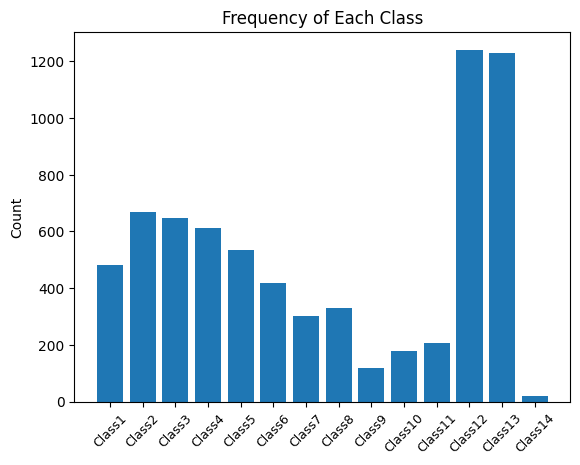

In [32]:
class_counts = y.sum(axis=0)

plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(class_counts)), y.columns, rotation=45,fontsize=9)
plt.ylabel("Count")
plt.title("Frequency of Each Class")

<h3 style="color:orange">Label Selection for Visualization</h3>

- after check the rowswise label sum we can observer that $\underline{\text{Most frequent single-label}}$ is **"Class1"** rest others are zero
- and from DataFrame below we can observer that the $\underline{\text{Most frequent multi-label combination}}$ is [**"Class3"**,**"Class4"**,**"Class12"**,**"Class13"**] 

In [ ]:
# for Most frequent single-label classes 
single_label_rows = y[y.sum(axis=1) == 1]
single_counts = single_label_rows.sum(axis=0).sort_values(ascending=False)
# 
top2_single = single_counts.index[:2].values
print(single_counts)

print(f"top 2 classes: {top2_single}")

Class1     20
Class2      0
Class3      0
Class4      0
Class5      0
Class6      0
Class7      0
Class8      0
Class9      0
Class10     0
Class11     0
Class12     0
Class13     0
Class14     0
dtype: object
top 2 classes: ['Class1' 'Class2']


In [34]:
# for Most frequent multi-label combination [for Visualization]
class_combinations=y.value_counts()

temp=pd.DataFrame(list(class_combinations.index),columns=[f"Class{i}" for i in range(1,15)])
temp["Counts"]=class_combinations.values
temp.to_csv("./temp/y_value_counts.csv",index=False)

combination_columns_names=temp.columns[temp.iloc[0,:]==1].values
combination_columns=np.array(class_combinations.idxmax())

print(f"\u001b[33mMost common multi-label combo:\u001b[0m {combination_columns_names}")
print(combination_columns)

temp.head(5)

Most common multi-label combo: ['Class4' 'Class5' 'Class12' 'Class13']
[0 0 0 1 1 0 0 0 0 0 0 1 1 0]


,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14,Counts
0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,197
1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,152
2,1,1,0,0,0,0,0,0,0,0,0,1,1,0,99
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,85
4,0,0,0,0,1,1,0,0,0,0,0,1,1,0,77


<h5 style="color:cyan">simplified label</h5>

In [ ]:
transformed_labels = []
for row in y.itertuples(index=False, name=None):
    row = np.array(row)
    
    if (row==combination_columns).all():  # exact most common multi-label combo
        transformed_labels.append("Most_Common_Combo")
    elif row.sum() == 1:  # single-label row
        class_name = y.columns[np.argmax(row)]
        if class_name in top2_single:
            transformed_labels.append(class_name)
        else:
            transformed_labels.append("Other")
        
    else:
        transformed_labels.append("Other")

transformed_labels = pd.Series(transformed_labels, name="Simplified")

print(transformed_labels.value_counts())

Simplified
Other                1419
Most_Common_Combo     197
Class1                 20
Name: count, dtype: int64


In [ ]:
# ### VERSION 2
# ### USE THIS TO CHECK FOR ["Class12","Class13"] which are most frequent as fer dataset

# from collections import Counter
# cnt=Counter()
# transformed_labels = []
# top2_single=["Class12","Class13"]

# for row in y.itertuples(index=False, name=None):
#     row = np.array(row)
    
#     if(row==combination_columns).all():  # exact most common multi-label combo
#         transformed_labels.append("Most_Common_Combo")
#     elif row.sum() == 4:  # single-label row
#         class_name = y.columns[y.shape[1]-(np.argmax(row[::-1])+1)]
#         # class_name = y.columns[np.argmax(row)]
#         cnt[class_name]+=1
#         if class_name in top2_single:
#             transformed_labels.append(class_name)
#         else:
#             transformed_labels.append("Other")

#     else:
#         transformed_labels.append("Other")

# transformed_labels = pd.Series(transformed_labels, name="Simplified")


# for k,v in cnt.items():
#     print(f"{k:<10}:{v}")
# print()
# print(transformed_labels.value_counts())

Class13   :470
Class6    :16
Class8    :12
Class12   :7
Class9    :16
Class4    :3
Class7    :3
Class11   :13
Class10   :4

Simplified
Other                962
Class13              470
Most_Common_Combo    197
Class12                7
Name: count, dtype: int64


<h3 style="color:orange">T-SNE + Visualization</h3>
T-SNE is a non-linear dimensionality reduction technique which is used for visualizing high-dimensional data and Revealing local structure within data.

---

<h5 style="color:cyan">Steps in T-SNE</h5>

- compute distances [probabilities]:
    - In the high dimensional space, T-SNE computes pairwise similarities how likely two points are neighbors.
    - for each point $x_i$ it defines the probability that $x_j$ would be it's neigbour:
    $$P_{i|j}=\frac{e^{-\frac{||x_i-x_j||^2}{2\sigma_i^2}}}{\sum_{k\ne i}e^{\frac{||x_i-x_k||^2}{2\sigma_i^2}}}$$
    - It uses a Gaussian (normal distribution) centered at $x_i$. Each point has its own variance $\sigma_i$ chosen via perplexity, which balances local vs global structure.
    - Then the joint probability of similarity is symmetrized 
    $$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2n}$$
- Low-dimensional embedding:
    - here it places points in 2D/3D such that their pairwise similarities match the original ones as closely as possible.
    - in low dimensional space, we again define similarity between points $y_i,y_j$. 
    - here **Student-t distribution** is used instead of a Gaussian to avoid the “crowding problem”
    $$q_{ij}=\frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\ne l} (1+||y_k-y_l||^2)^{-1}}$$
- compute divergence between distributions:
    - Measure how different high-dimensional similarities are from  low-dimensional similarities.
    - This difference is computed using **Kullback–Leibler (KL) divergence**
    $$C=KL(P||Q)=\sum\limits_{i\ne j} P_{ij} \log\frac{p_{ij}}{q_{ij}} $$
- minimization of divergence:
    - cost function minimizes the divergence between the probability distributions in high-dimensional and low-dimensional space.
- final embedding:
    - After convergence, the result is a 2D/3D map where:
        - Nearby points represent strongly similar high-dimensional samples.
        - Distant points represent dissimilar samples.
        - Small clusters and neighborhood structures are revealed.

---

<h5 style="color:cyan">Observation</h5>

after implementing T-SNE on this data for difffernt perplexity we can observe that **single class** data shows little dispersion and **multi class combination** form cluster like pattern. while **other** are scatter across the plane.
- as the level of perpexcity is increase we can also observer that the data points are forming cluster like pattern. which helps us to identify diffrent datapoint in the plane.
- the overlapping of datapoints has also been reduce. which we can see from 1st plot to last plot 

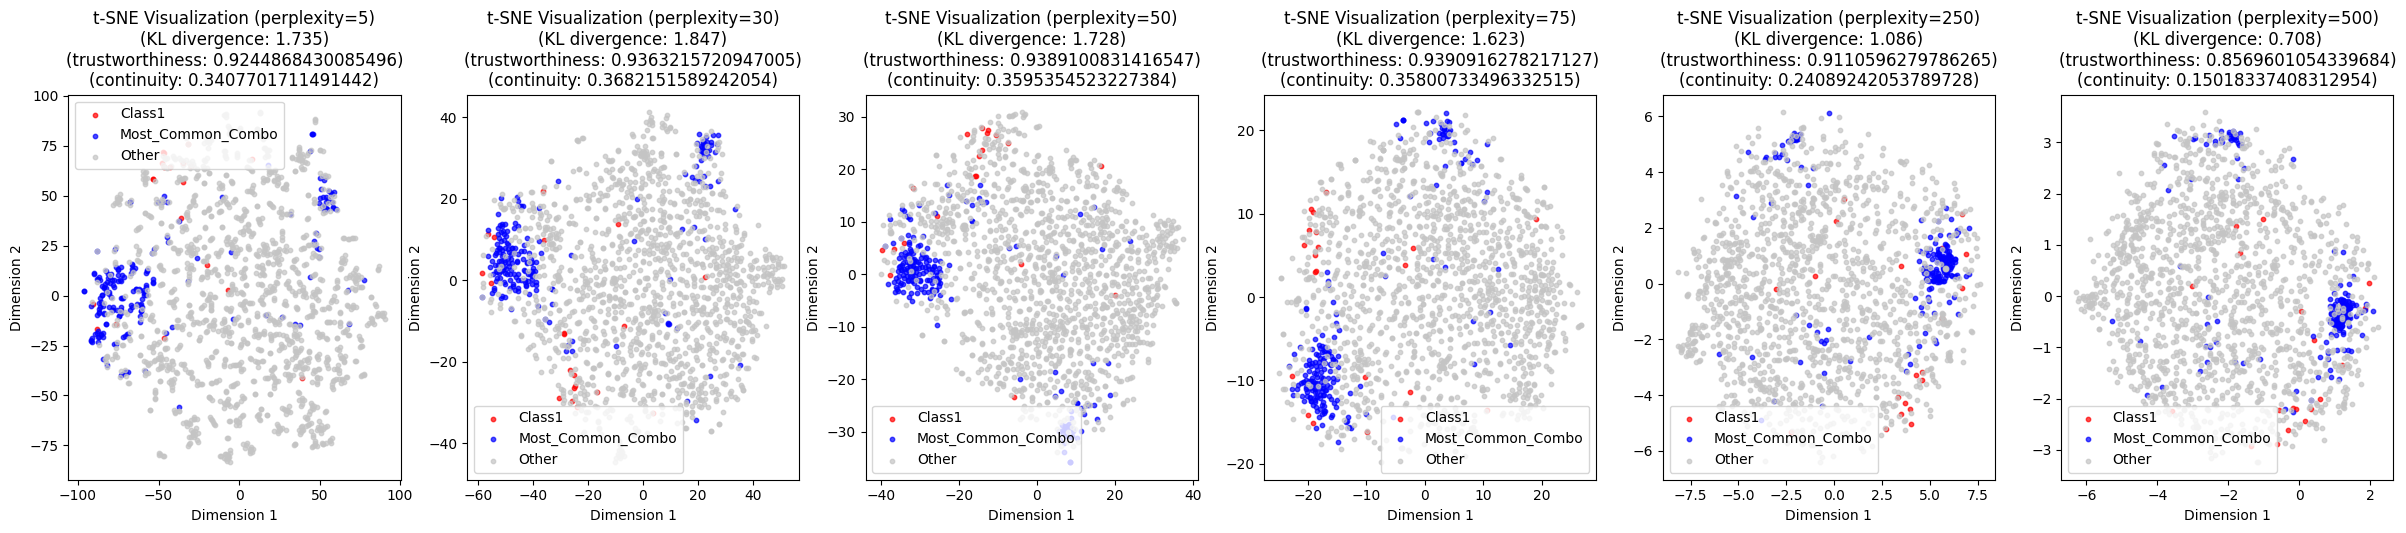

In [37]:
# perplexity=[5,30,50,75]
perplexity=[5,30,50,75,250,500]

fig,ax=plt.subplots(1,len(perplexity),figsize=(5*len(perplexity),5))

OUTPUT_TSNE={"x-tsne":[],"trustworthiness":[],"continuity":[]}

for i, p in enumerate(perplexity):
    model = TSNE(n_components=2, perplexity=p,max_iter=1500,learning_rate="auto",init="pca", random_state=42)
    x_tsne = model.fit_transform(x)
    
    kld=model.kl_divergence_
    tw = trustworthiness(x, x_tsne, n_neighbors=10)
    conti = continuity(x, x_tsne,n_neighbors=10)
    
    OUTPUT_TSNE["x-tsne"].append(x_tsne)
    OUTPUT_TSNE["trustworthiness"].append(tw)
    OUTPUT_TSNE["continuity"].append(conti)

    for label in np.unique(transformed_labels):
        idx = transformed_labels == label
        ax[i].scatter(x_tsne[idx,0], x_tsne[idx,1],
                    label=label, s=10, alpha=0.7,color=color_map.get(label,"black"))
    ax[i].set_xlabel("Dimension 1")
    ax[i].set_ylabel("Dimension 2")
    ax[i].legend()
    ax[i].set_title(f"t-SNE Visualization (perplexity={p})\n(KL divergence: {kld:.3f})\n(trustworthiness: {tw})\n(continuity: {conti})")

<h3 style="color:orange">Veracity Inspection</h3>

- **Noisy / Ambiguous Labels**:\
Here, noisy labels appear as isolated "Class1" (red) or "Most_Common_Combo" (blue) points embedded within dense "other" (gray) regions.  
  - For some "Class1" points appear inside a large gray cluster or in isloated groups.  
  - "Most_Common_Combo" points which are isolated from there cluster like pattern and scattered within gray-dominated clusters across all perplexities.

   These points likely represent mislabeled or ambiguous samples, where the data point spread patterns overlap with other functional classes. This suggests that the expression profile is more similar to another category but has been tagged differently.

- **Outliers**:\
here, Outliers are thoes points which are far away from the dense region. 
    - some "Class1" & "Most_Common_combo" points are located at outer boundry of the scatter plot. these point are isolated and don't have any close neightbours or form any small cluster like pattern.
    - these datapoint could be rare categories, or potential measurement noise in the dataset

- **Hard-to-Learn Samples**:\
the regions where "Class1", "Most_Common_combo", and "other" points are heavily mixed. are hard to learn samples. these samples don't form a clear boundry or cluster. which makes it difficlut to identify them as seprate cluster/region.

---

<h3 style="color:orange">Isomap</h3>

Isomap is also a non-linear dimensionality reduction technique that extends classical Multidimensional Scaling (MDS).
It’s mainly used for **manifold learning** → discovering the low-dimensional curved surface (“manifold”) that high-dimensional data lies on.

<h5 style="color:cyan">Steps in Isomap</h5>

- Construct a neighborhood graph
    - For each data point, connect it to its nearest neighbors.
    - Edges are weighted with the Euclidean distance between neighbors.
    $$w(i,j)=||x_i-x_j||$$
- Estimate geodesic distances
    - Approximate the shortest path between any two points along the graph.
    - This gives the geodesic distance matrix 𝐷. which can be calculate using Dijkstra’s algorithm or Floyd–Warshall algorithm 
- Apply classical MDS (Multidimensional Scaling)
    - MDS takes the geodesic distance matrix and finds a low-dimensional embedding where distances are preserved.
    - convert distance into inner-product (Gram Matrix).
    - Find low-dimensional coordinates $Y=\{y_1,\dots,y_n\}$ in d-dimensional space hat preserve those distances as closely as possible

- final embedding: 
    - here High-dimensional data is embedded into a lower dimension
    - points are placed in 2D/3D while maintaining manifold structure.


<h5 style="color:cyan">Observation</h5>

after implementing Isomap on this data from diffrent number of nearest neighbors we can observe the disperion between local and global strucuture. less overlaping occurs for datapoints. all though the cluster like patteern is still maintain
- as we increase the number of nearest neigbhour parameter we can see the reconstruction error reduces. but we lose local neighborhood information.

<h5 style="color:cyan">trade off between T-SNE & Isomap</h5>
The fundamental difference between Isomap and t-SNE lies in the type of structure they preserve.

- Isomap preserves the global geometry of the data manifold by maintaining geodesic distances between all points, 
- whereas t-SNE preserves local neighborhood relationships by modeling pairwise similarities.

Consequently, Isomap captures the overall shape of the manifold, while t-SNE focuses on revealing local clusters and patterns.

on this dataset we can observe that the T-SNE has gave us some cluster like pattern, where as for Isomap has given us distribution spread like pattern across plane while maining cluster forming pattern

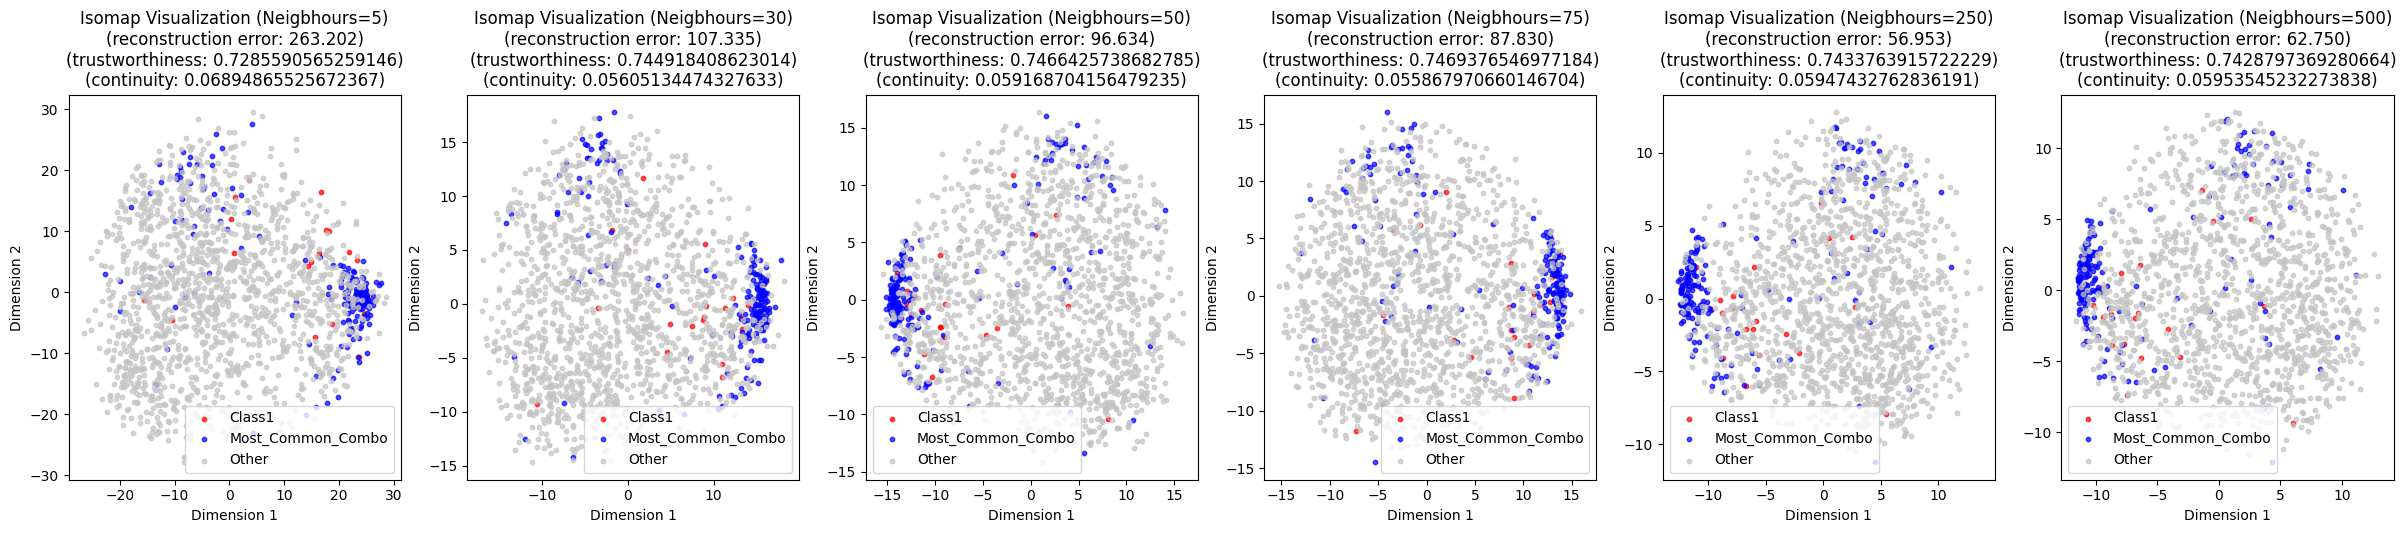

In [38]:
# neigbhours=[5,30,50,75]
neigbhours=[5,30,50,75,250,500]

fig,ax=plt.subplots(1,len(neigbhours),figsize=(5*len(neigbhours),5))

OUTPUT_ISOMAP={"isomap":[],"trustworthiness":[],"continuity":[]}
for i,N in enumerate(neigbhours):
    model=Isomap(n_components=2, n_neighbors=N)
    x_isomap = model.fit_transform(x)
    reconstruction_error=model.reconstruction_error()
    tw = trustworthiness(x, x_isomap, n_neighbors=10)
    conti=continuity(x,x_isomap,n_neighbors=10)
    # tw = trustworthiness(x, x_isomap, n_neighbors=N)
    # conti=continuity(x,x_isomap,n_neighbors=N)

    OUTPUT_ISOMAP["isomap"].append(x_isomap)
    OUTPUT_ISOMAP["trustworthiness"].append(tw)
    OUTPUT_ISOMAP["continuity"].append(conti)

    for label in np.unique(transformed_labels):
        idx = transformed_labels == label
        ax[i].scatter(x_isomap[idx,0], x_isomap[idx,1],
                    label=label, s=10, alpha=0.7,color=color_map.get(label,"black"))
    
    ax[i].set_xlabel("Dimension 1")
    ax[i].set_ylabel("Dimension 2")
    ax[i].legend()
    ax[i].set_title(f"Isomap Visualization (Neigbhours={N})\n(reconstruction error: {reconstruction_error:.3f})\n(trustworthiness: {tw})\n(continuity: {conti})")

<h3 style="color:orange">Comparison and Curvature</h3>

here **Isomap** proves to be good for revealing the global structure of the gene expression data. because it preserves the global geometry of the data manifold by maintaining geodesic distances between all points


<h5 style="color:cyan">Data Manifold</h5>
A data manifold is the underlying continuous, low-dimensional surface embedded within a higher-dimensional space where your data actually lies. considerning this dataset there are 102 features, where data does't completedly fills 102 Dimiesional spaces. insted in lies on much lower dimension curve surface (manifold). our goal here was to "unfold" those manifold data and represent it in fewer dimension for visulization or analysis. 

the Isomap visulization on this dataset tells us that:
- Moderate values of `n_neighbors` reveal a **smooth but nonlinear** structure with curved clusters.  
- As `n_neighbors` increases, the embeddings begin to **collapse**, suggesting that the manifold is **highly curved and complex** rather than flat or linear.

The Isomap embeddings therefore indicate that the yeast data lies on a **nonlinear, curved manifold** with overlapping clusters.  

This curvature implies that the relationships among samples are **nonlinear**, making it challenging for simple linear classifiers to separate the classes effectively.

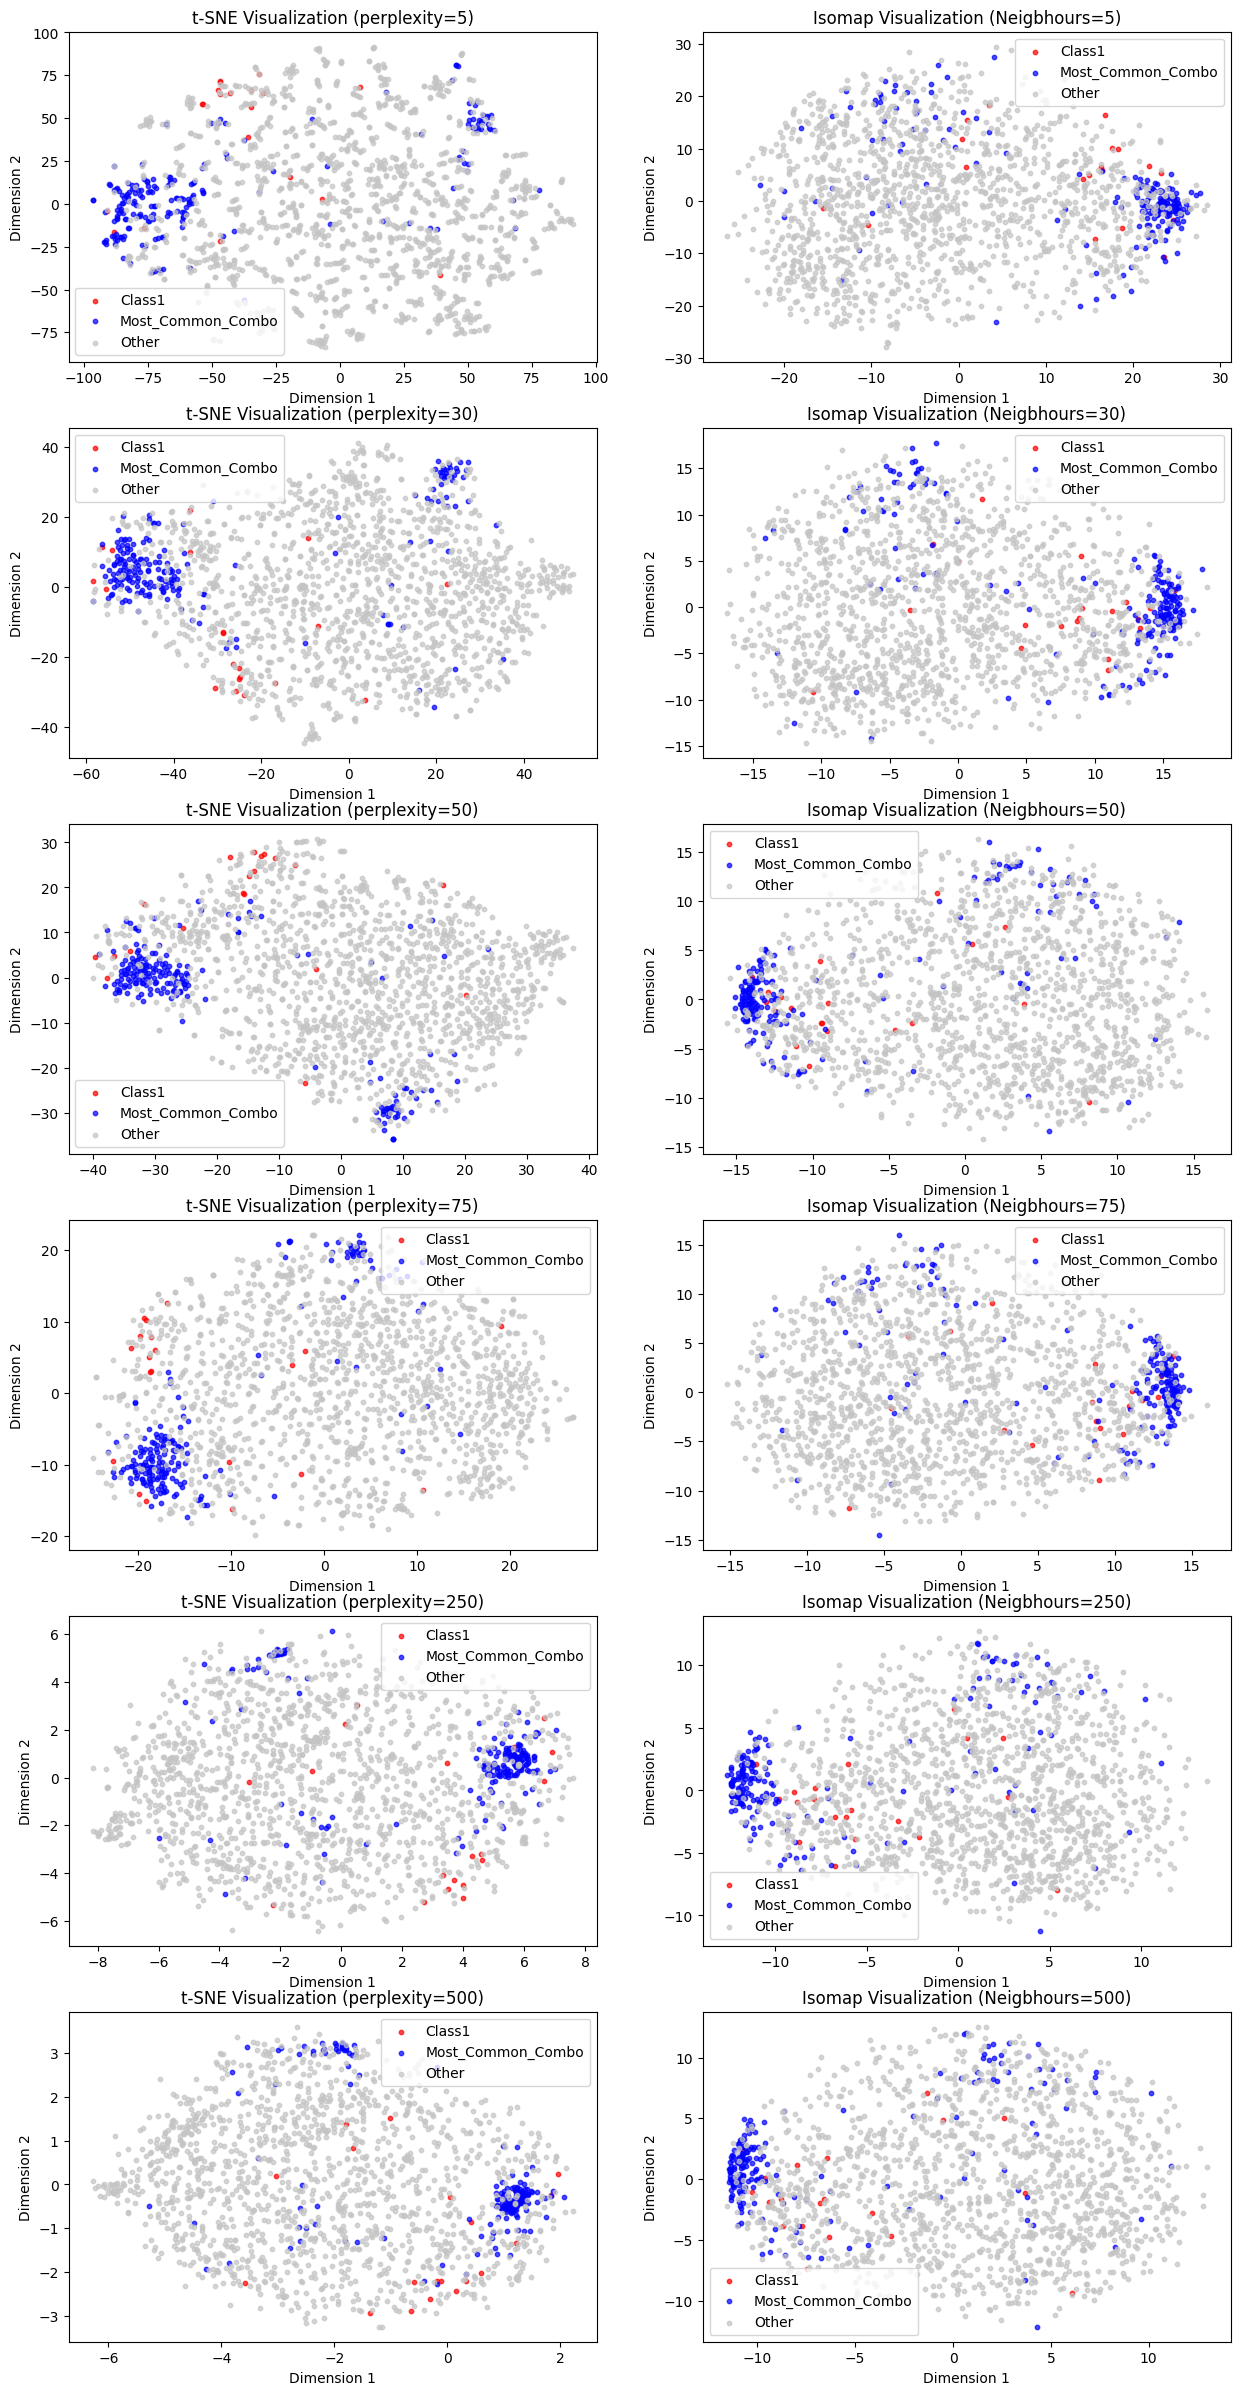

In [39]:
fig,ax=plt.subplots(len(OUTPUT_TSNE["x-tsne"]),2,figsize=(15,5*len(OUTPUT_TSNE["x-tsne"])))

for i in range(len(OUTPUT_TSNE["x-tsne"])):
    
    for label in np.unique(transformed_labels):
        idx = (transformed_labels == label)
        ax[i,0].scatter(OUTPUT_TSNE["x-tsne"][i][idx,0],OUTPUT_TSNE["x-tsne"][i][idx,1],label=label, s=10, alpha=0.7,color=color_map.get(label,"black"))
        ax[i,0].set_title(f"t-SNE Visualization (perplexity={perplexity[i]})")
        ax[i,0].set_xlabel("Dimension 1")
        ax[i,0].set_ylabel("Dimension 2")
        ax[i,0].legend()

        ax[i,1].scatter(OUTPUT_ISOMAP["isomap"][i][idx,0],OUTPUT_ISOMAP["isomap"][i][idx,1],label=label, s=10, alpha=0.7,color=color_map.get(label,"black"))
        ax[i,1].set_title(f"Isomap Visualization (Neigbhours={neigbhours[i]})")
        ax[i,1].set_xlabel("Dimension 1")
        ax[i,1].set_ylabel("Dimension 2")
        ax[i,1].legend()

<h3 style="color:orange">Trustworthiness and Continuity Analysis</h3>

- **Trustworthiness** evaluates how well local neighborhoods in the original space are preserved in the embedding.  
- **Continuity** measures how well neighborhoods in the embedding exist in the original space.  
t-SNE tends to have higher **trustworthiness** (preserves local structure), while Isomap tends to have higher **continuity** (preserves global geometry).


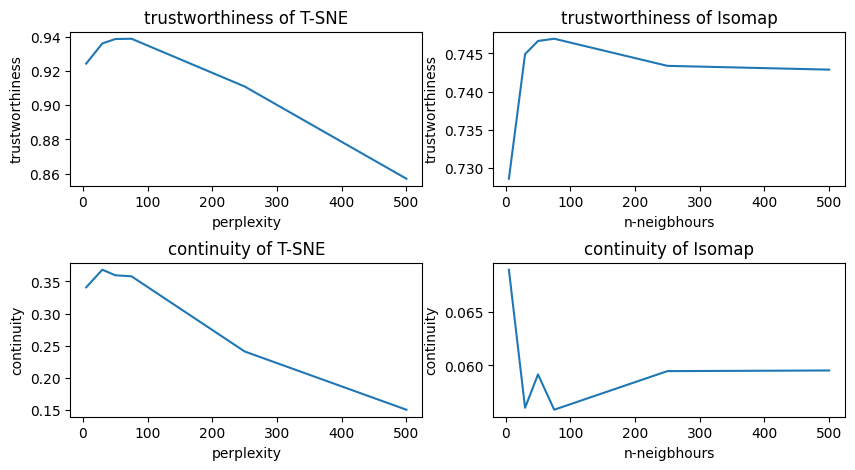

In [40]:
fig,ax=plt.subplots(2,2,figsize=(10,5))

ax[0,0].plot(perplexity,OUTPUT_TSNE["trustworthiness"])
ax[0,0].set_title("trustworthiness of T-SNE")
ax[0,0].set_xlabel("perplexity")
ax[0,0].set_ylabel("trustworthiness")
ax[1,0].set_ylabel("continuity")

ax[1,0].plot(perplexity,OUTPUT_TSNE["continuity"])
ax[1,0].set_xlabel("perplexity")
ax[1,0].set_title("continuity of T-SNE")

# 
ax[0,1].plot(neigbhours,OUTPUT_ISOMAP["trustworthiness"])
ax[0,1].set_title("trustworthiness of Isomap")
ax[0,1].set_xlabel("n-neigbhours")
ax[0,1].set_ylabel("trustworthiness")

ax[1,1].plot(neigbhours,OUTPUT_ISOMAP["continuity"])
ax[1,1].set_title("continuity of Isomap")
ax[1,1].set_xlabel("n-neigbhours")
ax[1,1].set_ylabel("continuity")

plt.subplots_adjust(wspace=0.2,hspace=0.5)

The **continuity score** of Isomap is notably lower than that of t-SNE due to their fundamental difference in how they preserve data structure.  
t-SNE focuses on maintaining **local neighborhood relationships**, ensuring that points that are close together in the high-dimensional space remain close in the low-dimensional embedding.  
This strong emphasis on local structure results in **higher continuity**, meaning that most neighboring points in the reduced space correspond to true neighbors in the original data.

On the other hand, **Isomap** aims to preserve **global geodesic distances** across the entire manifold rather than focusing on local pairwise similarities.  
While this approach captures the broader geometric layout of the dataset, it tends to **distort fine-grained local relationships**, especially in nonlinear or noisy data.  
As a result, nearby points in the Isomap embedding may not correspond to true neighbors in the original space, leading to a **lower continuity score**.  
This effect is especially evident in complex biological datasets like the yeast data, where local structure is crucial for accurate neighborhood representation.

<h3 style="color:orange">Conclusion</h3>

here we can observe that:

- **t-SNE** is a *local structure-preserving* method.  
  It focuses on preserving pairwise similarities between nearby points, which makes it excellent for revealing small, dense clusters. However, it does not preserve global distances well – clusters may be arbitrarily spaced apart.
  - in comparition plot we can observer that for lower perplexity datapoints are fragmented, as the perplexity increases we get smoother datapoint distribution in form of small cluster like forms.  

- **Isomap** is a *global structure-preserving* method.  
  It computes geodesic distances along the data manifold, and then applies Multidimensional Scaling (MDS). This means Isomap captures the overall geometry and curved structure of the dataset, at the cost of less detailed local clustering.
  - in comparition plot we can observer that for lower n-neighbors datapoints are overlaped with "other" datapoints, as the n-neighbors increases we get datapoints with better dispersion to revels is global struture .  

Key Difference between both techiques
- t-SNE preserves **local neighborhoods** → better for visualizing small, tight clusters.  
- Isomap preserves **global manifold structure** → better for visualizing the overall shape of the data and how clusters are arranged relative to each other.

for this this dataset
- The best visualization was obtained at **perplexity = 50**, which provided a good balance between local neighborhood preservation and global structure for **T-SNE**. it effectively revealed local clusters in the yeast data, making it ideal for exploring small-scale structure and identifying overlapping or ambiguous samples.
- thr stable manifold quality was achived when The **reconstruction error** dropped sharply up to around **n-neighbors = 30–50**, then flattened. it has successfully captured the **global manifold curvature**, revealing the overall shape of the yeast feature space, though at the cost of fine local cluster separation.

<h5 style="color:cyan">Comparative Insights</h5>

| Property | t-SNE | Isomap |
|-----------|-------|--------|
| Preserves | Local structure | Global structure |
| Ideal parameter | Perplexity = 50 | Neighbors = 50 |
| Strength | Reveals small, tight clusters | Captures manifold curvature |
| Limitation | Poor global distance preservation | May smooth out local details |

<h5 style="color:cyan">Observations on Data Quality</h5>

- **Noisy / Ambiguous Labels:** Single red or blue points embedded within gray clusters indicate samples with overlapping class features or possible mislabels.  
- **Outliers:** Isolated points far from dense clusters suggest unusual gene expression patterns.  
- **Hard-to-learn samples:** Mixed-color regions imply overlapping functional categories that challenge simple classifiers.